### Install required Packages

In [1]:
!pip install ffmpeg-python &> 0
!pip install tensorflow-io &> 0
!pip install python_speech_features &> 0
print("Packages Installed")

Packages Installed


### Import everything we will need

In [2]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import mfcc
from matplotlib import cm
import pickle
import librosa
print("Packages Imported")

Packages Imported


In [16]:
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

print("Chrome Audio Recorder Defined")

Chrome Audio Recorder Defined


# Load in the Audio Samples
### Record your own audio samples!
After you run each cell wait for the stop button to appear then start recording and then press the button to stop the recording once you have said the word! **If you do not want to record audio then see below for a way to load in the default audio used in the lecture slides.**

In [8]:
audio_yes_loud, sr_yes_loud = get_audio()
print("DONE")

DONE


In [9]:
audio_yes_quiet, sr_yes_quiet = get_audio()
print("DONE")

DONE


In [10]:
audio_no_loud, sr_no_loud = get_audio()
print("DONE")

DONE


In [11]:
audio_no_quiet, sr_no_quiet = get_audio()
print("DONE")

DONE


# Visualize the samples
### First as signals

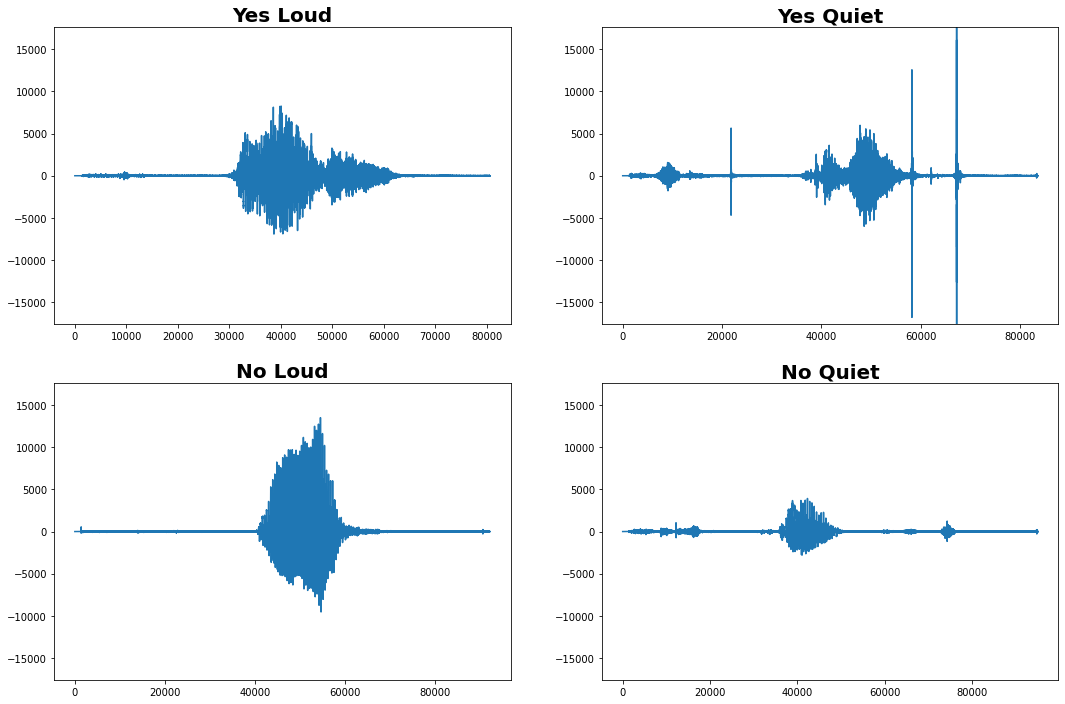

In [12]:
# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = max(np.append(np.append(np.append(audio_yes_loud,audio_yes_quiet),audio_no_loud),audio_no_quiet))
ax1.plot(audio_yes_loud)
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_yes_quiet)
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_no_loud)
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_no_quiet)
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)

### Then view the Fourier Transform of the Signal
Viewing the signal in the frequency domain.

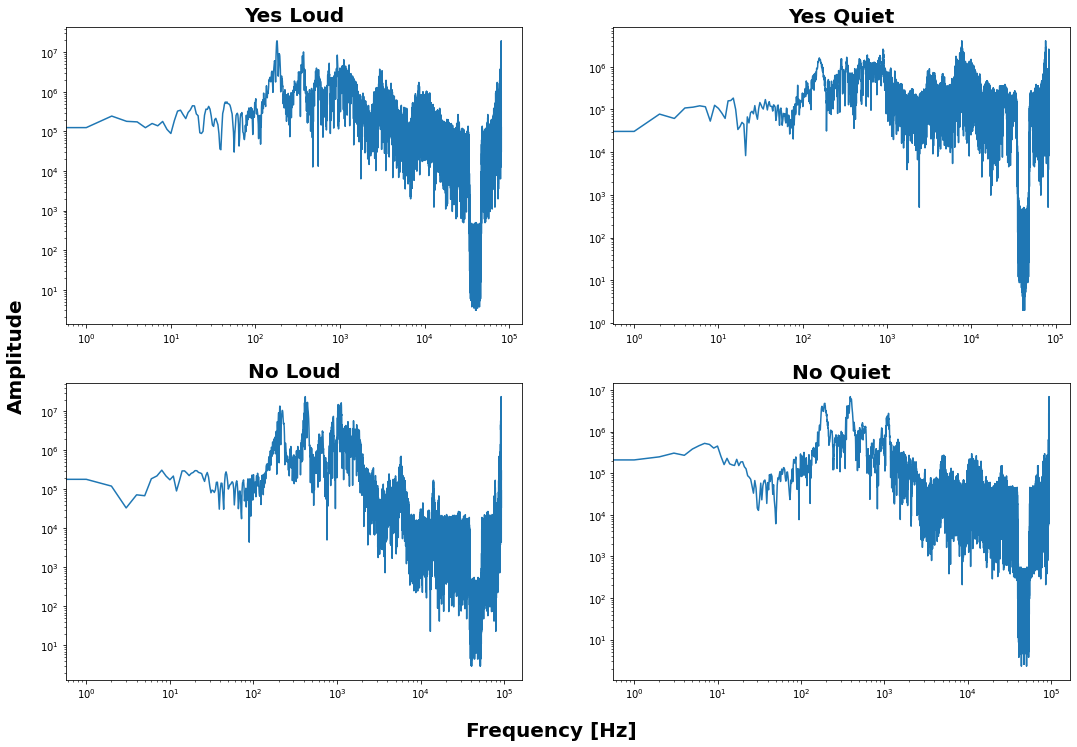

In [13]:
#Adapted from https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
# compute the FFT and take the single-sided spectrum only and remove imaginary part
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ft_audio_yes_loud = np.abs(2*np.fft.fft(audio_yes_loud))
ft_audio_yes_quiet = np.abs(2*np.fft.fft(audio_yes_quiet))
ft_audio_no_loud = np.abs(2*np.fft.fft(audio_no_loud))
ft_audio_no_quiet = np.abs(2*np.fft.fft(audio_no_quiet))

# Plot the figure
ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

### Then as spectrograms
Can you see how spectrograms can help machine learning models better differentiate between audio samples?

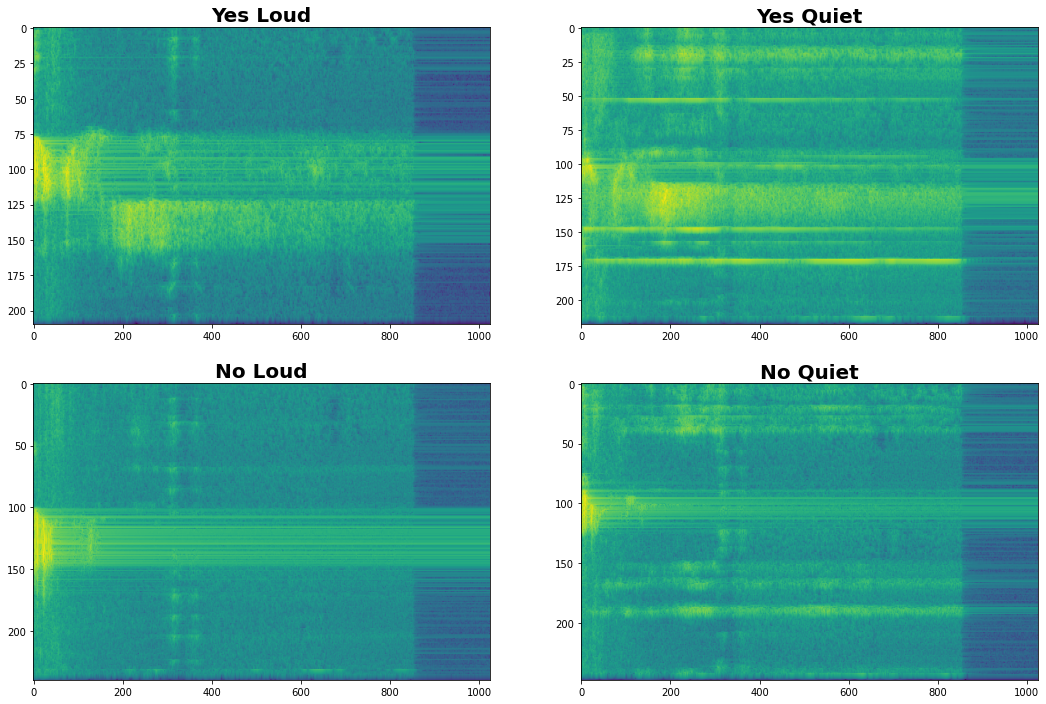

In [14]:
# Convert to spectrogram and display
# adapted from https://aruno14.medium.com/comparaison-of-audio-representation-in-tensorflow-b6c33a83d77f
spectrogram_yes_loud = tfio.experimental.audio.spectrogram(audio_yes_loud/1.0, nfft=2048, window=len(audio_yes_loud), stride=int(sr_yes_loud * 0.008))
spectrogram_yes_quiet = tfio.experimental.audio.spectrogram(audio_yes_quiet/1.0, nfft=2048, window=len(audio_yes_quiet), stride=int(sr_yes_quiet * 0.008))
spectrogram_no_loud = tfio.experimental.audio.spectrogram(audio_no_loud/1.0, nfft=2048, window=len(audio_no_loud), stride=int(sr_no_loud * 0.008))
spectrogram_no_quiet = tfio.experimental.audio.spectrogram(audio_no_quiet/1.0, nfft=2048, window=len(audio_no_quiet), stride=int(sr_no_quiet * 0.008))

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(tf.math.log(spectrogram_yes_loud).numpy(), aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.imshow(tf.math.log(spectrogram_yes_quiet).numpy(), aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.imshow(tf.math.log(spectrogram_no_loud).numpy(), aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.imshow(tf.math.log(spectrogram_no_quiet).numpy(), aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)

### Then as MFCCs
Using the Mel Scale to better associate the features to human hearing!

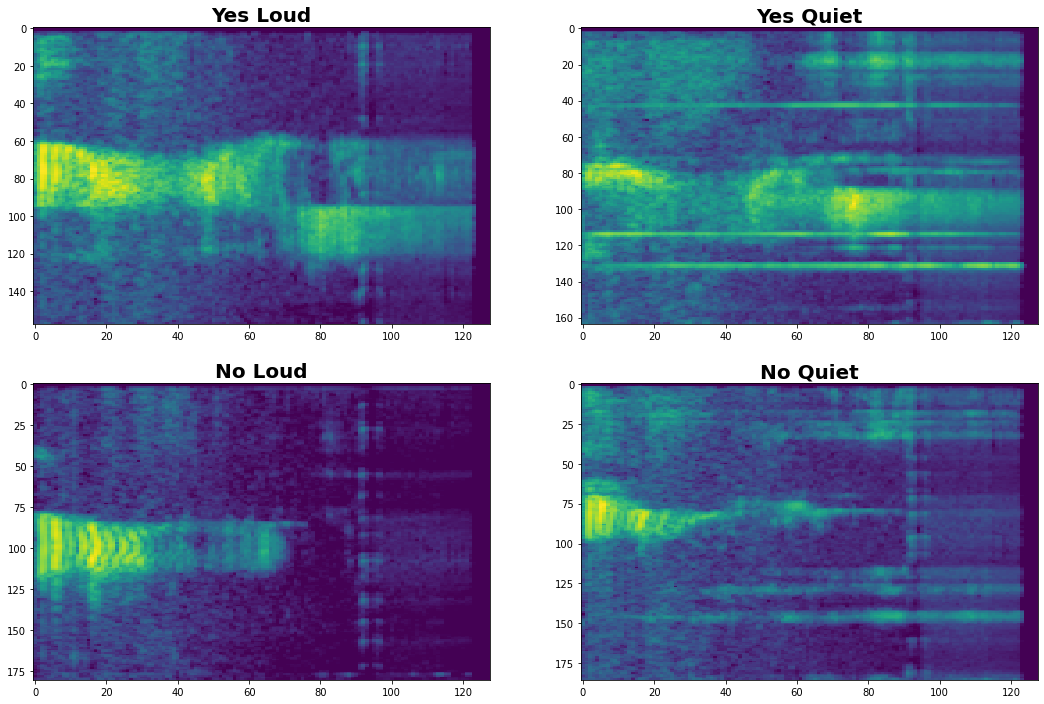

In [15]:
# Convert to MFCC using the Mel Scale
# adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
mfcc_yes_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_loud), sr=sr_yes_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_yes_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_quiet), sr=sr_yes_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_loud), sr=sr_no_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_quiet), sr=sr_no_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(mfcc_yes_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_yes_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_no_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_no_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)